<a href="https://colab.research.google.com/github/monicafar147/classification-predict-streamlit-template/blob/EDA/climate_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Installing comet

In [ ]:
!pip install comet_ml

     |████████████████████████████████| 215kB 2.8MB/s 
     |████████████████████████████████| 419kB 8.6MB/s 
     |████████████████████████████████| 204kB 14.2MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=7bc24efc721f4bad005dea82f1059434d2154132a21eb4b434acbdb1ffff2309
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


In [ ]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="rBqQ3hDuEa6xVpT9ns5Tz1dVt",
                        project_name="nlp-climate-change",
                        workspace="monicafar147")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/monicafar147/nlp-climate-change/bec709f2c15d44b3883fac82d10b816e



## Importing the modules

In [1]:
import numpy as np 
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')

# text preprocessing
import re
from string import punctuation
import nltk
nltk.download(['stopwords','punkt'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word
from wordcloud import WordCloud, STOPWORDS

# models
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Importing the data

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/monicafar147/classification-predict-streamlit-template/master/climate-change-belief-analysis/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/monicafar147/classification-predict-streamlit-template/master/climate-change-belief-analysis/test.csv")

In [3]:
print("Train\n")
print(train.head(5))
print("\nTest")
print(test.head(5))

Train

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

Test
                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


# EDA

First we see if there are any repeats or Null values in the dataset


In [5]:
# Checking that there is no repeats in the Data

unique = [row for row in train['tweetid'].unique()]
print("Number of unique values")
print(train['tweetid'].nunique())
print("\nTotal number of values")
print(len(train['tweetid']))
print("\nNumber of null values:\n" + str(train.isnull().sum()))

Number of unique values
15819

Total number of values
15819

Number of null values:
sentiment    0
message      0
tweetid      0
dtype: int64


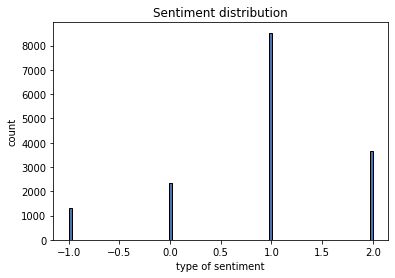

In [6]:
# We plot a graph to see the sentiment distribution
plt.hist(train['sentiment'], bins = 100, edgecolor = 'k')
plt.xlabel('type of sentiment')
plt.ylabel('count')
plt.title('Sentiment distribution')
plt.show()

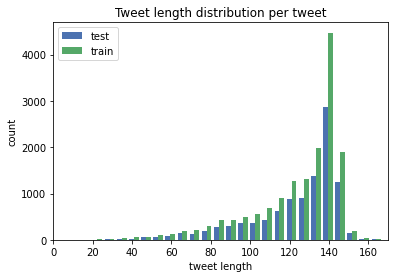

In [7]:
# Explore the word count and tweet lengths
train['length'] = train['message'].astype(str).apply(len)
train['word_count'] = train['message'].apply(lambda x: len(str(x).split()))
test['length'] = test['message'].astype(str).apply(len)
test['word_count'] = test['message'].apply(lambda x: len(str(x).split()))

# Creating the plot
plt.hist([test['length'], train['length']], bins=100, label=['test', 'train'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

**And now for the word length distribution**

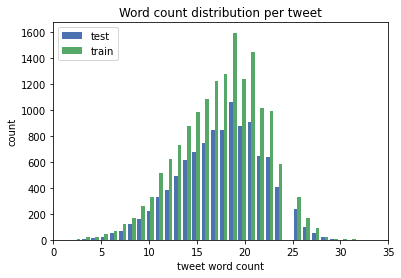

In [8]:
plt.hist([test['word_count'], train['word_count']], bins=100, label=['test', 'train'])
plt.title('Word count distribution per tweet')
plt.xlabel('tweet word count')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,35])
plt.show()

So now we will create word clouds based on the two datasets to get insights into which words are the most common and hopefully being able to better understand how the model works

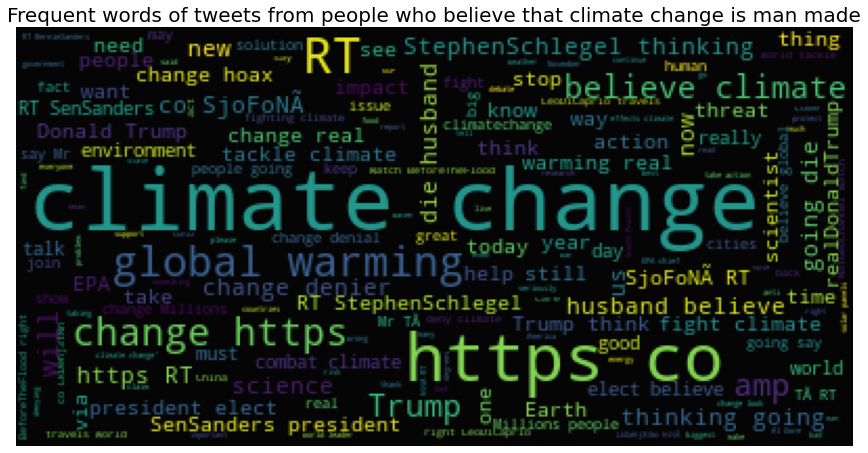

In [9]:
# Creating the word cloud
rnd_comments = train[train['sentiment']==1].sample(n=2000)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comments))
# Plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets from people who believe that climate change is man made', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

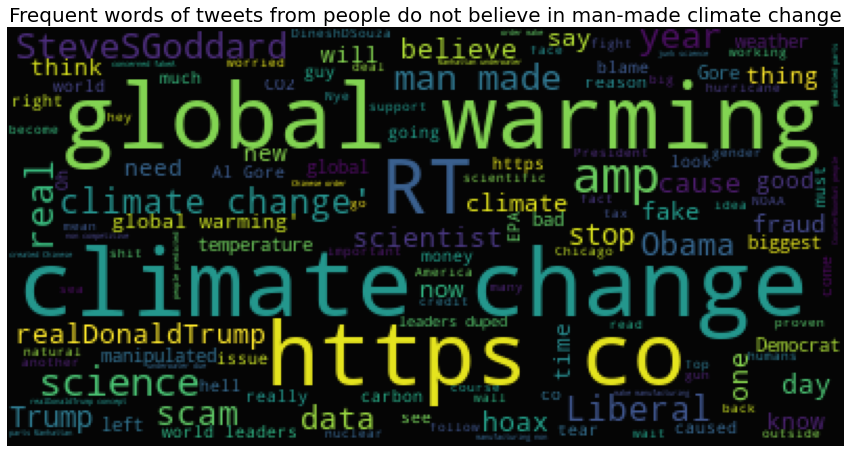

In [10]:
# Creating the word cloud
rnd_comment = train[train['sentiment']==-1].sample(n=200)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comment))

#plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets from people do not believe in man-made climate change', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

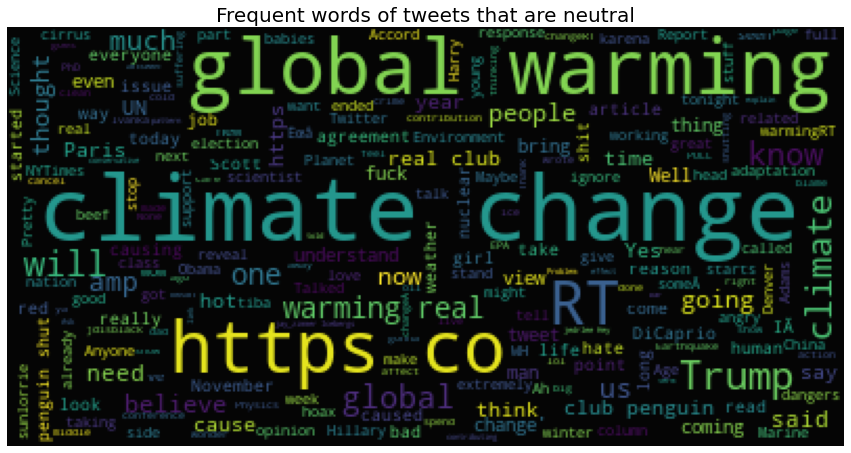

In [11]:
# Creating the word cloud
rnd_comment = train[train['sentiment']==0].sample(n=200)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comment))

#plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets that are neutral', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

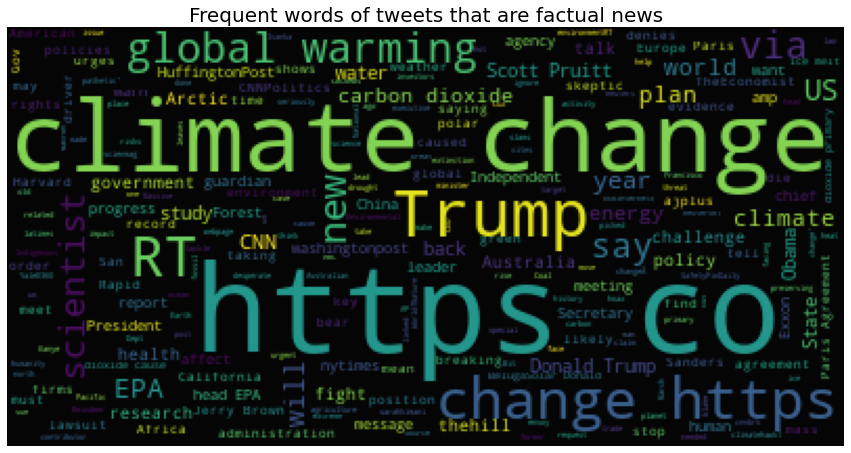

In [12]:
# Creating the word cloud
rnd_comment = train[train['sentiment']==2].sample(n=200)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comment))

#plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets that are factual news', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

**These are the most common Hashtags and @Users in the train dataset**

In [13]:
# Anti
anti = train[train['sentiment']==-1]
a_tweets = anti['message']
series_a = a_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

# Pro
pro = train[train['sentiment']==1]
p_tweets = pro['message']
series_p = p_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

# Neutral
neutral = train[train['sentiment']==0]
neutral_tweets = neutral['message']
series_neutral = neutral_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

# News
news = train[train['sentiment']==2]
news_tweets = news['message']
series_news = news_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

print("\033[1mAnti Climate change most common hashtags\033[0m\n" + str(series_a))
print("\n")
print("\033[1mPro Climate change most common hashtags\033[0m\n" + str(series_p))
print("\n")
print("\033[1mNeutral Climate change most common hashtags\033[0m\n" + str(series_neutral))
print("\n")
print("\033[1mNews Climate change most common hashtags\033[0m\n" + str(series_news))

Anti Climate change most common hashtags
#MAGA                             11
#climate                          10
#Trump                             7
#climatechange                     6
#ParisAgreement                    4
                                  ..
#ThingsTrumpThinksAreOverrated     1
#BlameRussia                       1
#Jan20                             1
#globalcooling                     1
#POTUS                             1
Name: 0, Length: 178, dtype: int64


Pro Climate change most common hashtags
#climate            187
#BeforeTheFlood     129
#climatechange       94
#ImVotingBecause     62
#COP22               59
                   ... 
#Lexa                 1
#abpoli               1
#futureofwork         1
#3                    1
#gooutside            1
Name: 0, Length: 1255, dtype: int64


Neutral Climate change most common hashtags
#climate           16
#Trump             11
#climatechange     11
#BeforeTheFlood     4
#amreading          4
                   

**Now we do the same thing but with the @ to see these tweets are mostly directed at**

In [15]:
#Anti
usernames_anti = a_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

# Pro
usernames_pro = p_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

# Neutral
usernames_neutral = neutral_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

# News
usernames_news = news_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

print("\033[1mAnti Climate change most common tweets\033[0m\n" + str(usernames_anti))
print("\n")
print("\033[1mPro Climate change most common tweets\033[0m\n" + str(usernames_pro))
print("\n")
print("\033[1mNeutral Climate change most common tweets\033[0m\n" + str(usernames_neutral))
print("\n")
print("\033[1mNews Climate change most common tweets\033[0m\n" + str(usernames_news))


Anti Climate change most common tweets
@realDonaldTrump    71
@SteveSGoddard      44
@PrisonPlanet       20
@CounterMoonbat     16
@FoxNews            11
                    ..
@KathyMschotschi     1
@T_S_P_O_O_K_Y       1
@BigJimSports        1
@ManMadeMoon         1
@HktkPlanet          1
Name: 0, Length: 920, dtype: int64


Pro Climate change most common tweets
@StephenSchlegel    307
@SenSanders         245
@realDonaldTrump    164
@LeoDiCaprio        129
@BernieSanders      123
                   ... 
@baddestmamajama      1
@AndryWaseso          1
@Kris_Sacrebleu       1
@QLDLabor             1
@SenToomey            1
Name: 0, Length: 4504, dtype: int64


Neutral Climate change most common tweets
@realDonaldTrump    31
@CivilJustUs        20
@ULTRAVlOLENCE      20
@CNN                12
@jay_zimmer         10
                    ..
@business            1
@2Marrr              1
@jenditchburn        1
@herandrews          1
@Will_Garber         1
Name: 0, Length: 1881, dtype: int64


from this alone we can see that people who belive in climate change tend to tweet with alot more hashtags

In [16]:
rts = [0]
op =[]
for i in train['message']:
  if 'RT' in i:
    rts.append(i)
  else:
    op.append(i)

print("Number of Original Tweets: " + str(len(op)))
print("\nNumber of Retweets: " + str(len(rts)))
print("\nRatio of Orignal Tweets to retweets: " + str(round(len(op)/len(rts),2)))

Number of Original Tweets: 6133

Number of Retweets: 9687

Ratio of Orignal Tweets to retweets: 0.63


We can see by this that there are alot more retweets in the data so this might have duplicate rows but if we get rid of them this will very sorely impact the number of data points we have to train, and the more the merrier

# Data preprocessing
Combine the train and test data in order to do preprocessing on both datasets. This is essential to test the models being built. This step will also be useful for implementing the API.

Before preprocessing we need to ask ourseleves the following questions about this data:
1. does URL have impact on tweet sentiment?
2. does retweet have any impact on tweet sentiment?
3. does removing hashtags remove sentment?
4. contractions are a problem - removing doesn't -> does




Creating a function which will preprocess all of our data.


In [ ]:
def preprocess(tweet):
  tweet = tweet.lower()
  tweet = re.sub(r"\W", " ", tweet)
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet) 
  tweet = word_tokenize(tweet)
  stopwords_list = set(stopwords.words('english') + list(punctuation))
  tweets = [word for word in tweet if word not in stopwords_list]
  return " ".join(tweet)

In [ ]:
# Splitting the labels and features
train['processed'] = train['message'].apply(preprocess)
X = train['processed']
y = train['sentiment']

In [ ]:
# print out cleaned text
index = 1
for tweet in X[0:10]:
    print(str(index)+": " + tweet)
    print('\n')
    index += 1

1: polyscimajor epa chief doesn t think carbon dioxide is main cause of global warming and wait what https t co yelvcefxkc via mashable


2: it s not like we lack evidence of anthropogenic global warming


3: rt rawstory researchers say we have three years to act on climate change before it s too late https t co wdt0kdur2f https t co z0anpt


4: todayinmaker wired 2016 was a pivotal year in the war on climate change https t co 44wotxtlcd


5: rt soynoviodetodas it s 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight


6: worth a read whether you do or don t believe in climate change https t co gglzvnyjun https t co 7afe2mah8j


7: rt thenation mike pence doesn t believe in global warming or that smoking causes lung cancer https t co gvwyaauu8r


8: rt makeandmendlife six big things we can all do today to fight climate change or how to be a climate activistã â â https t co tymlu6dbnm hã â â


9: aceofspadeshq my 8yo nephew is inconsolable he want

At this point the text is clean, preprocessed and ready to be modelled.


In [ ]:
# preprocess testing data
test['processed'] = test['message'].apply(preprocess)

# Data EDA after Pre-processing

In [ ]:
# explore the word count and tweet lengths
train['length after'] = train['processed'].astype(str).apply(len)
train['word_count after'] = train['processed'].apply(lambda x: len(str(x).split()))
test['length after'] = test['processed'].astype(str).apply(len)
test['word_count after'] = test['processed'].apply(lambda x: len(str(x).split()))

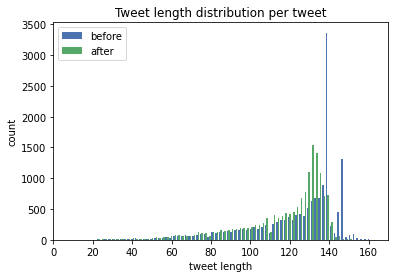

In [ ]:
plt.hist([train['length'], train['length after']], bins=100, label=['before', 'after'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

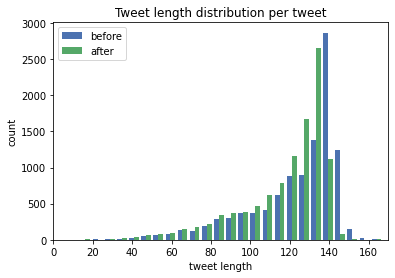

In [ ]:
plt.hist([test['length'], test['length after']], bins=100, label=['before', 'after'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

In [ ]:
# frequency of commonly used words.

# Modelling


## Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the labels and fetures into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [ ]:
# plot train vs test

## Declare models

In [ ]:
# apply model on train data using Linear SVC:
svc = Pipeline([('tfidf',TfidfVectorizer()),('classify',LinearSVC())])
svc.fit(X_train, y_train)

#apply model on test data
y_pred = svc.predict(X_test)

## Predicting

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
report_1 = print(classification_report(y_test, y_pred))
report_1

              precision    recall  f1-score   support

          -1       0.67      0.52      0.59       126
           0       0.66      0.42      0.52       224
           1       0.80      0.86      0.83       895
           2       0.75      0.83      0.79       337

    accuracy                           0.77      1582
   macro avg       0.72      0.66      0.68      1582
weighted avg       0.76      0.77      0.76      1582



In [ ]:
x_unseen = test['processed']
y_prediction = svc.predict(x_unseen)

# Saving the prediction to submit

In [ ]:
Final = test['tweetid']

Final_Table = {'tweetid': Final, 'sentiment':np.round(y_prediction, 0)}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['tweetid', 'sentiment']]


submission.set_index('tweetid')

,sentiment
tweetid,
169760,1
35326,1
224985,1
476263,1
872928,0
...,...
895714,1
875167,1
78329,2


In [ ]:
# Only run this code if wanting to save to a CSV file
# save to .csv file
#submission.to_csv("kaggle_mon.csv",index  = False)

# Comet version control

In [ ]:
print("\nResults\nConfusion matrix \n {}".format(
    confusion_matrix(y_test, y_pred)))


Results
Confusion matrix 
 [[ 66  13  41   6]
 [ 12  95 103  14]
 [ 17  33 774  71]
 [  4   3  51 279]]


In [ ]:
report = classification_report(y_test, y_pred)
print("\nResults\nClassification report \n {}".format(
    report))


Results
Classification report 
               precision    recall  f1-score   support

          -1       0.67      0.52      0.59       126
           0       0.66      0.42      0.52       224
           1       0.80      0.86      0.83       895
           2       0.75      0.83      0.79       337

    accuracy                           0.77      1582
   macro avg       0.72      0.66      0.68      1582
weighted avg       0.76      0.77      0.76      1582



In [ ]:
# Create dictionaries for the data we want to log

params = {"preprocessing":  "_preprocess_V4(df)",
          "keeps username":"True",
          "keeps hashtags":"True",
          "keeps URL":"urlweb",
          "removes puncutation":"string punctuation",
          "use stopwords":"False",
          "model_type": "LinearSVC",
          }

metrics = {"report" : report,
           }

In [ ]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metric("report",report)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/monicafar147/nlp-climate-change/bec709f2c15d44b3883fac82d10b816e
COMET INFO:   Metrics:
COMET INFO:     report :               precision    recall  f1-score   support

          -1       0.67      0.52      0.59       126
           0       0.66      0.42      0.52       224
           1       0.80      0.86      0.83       895
           2       0.75      0.83      0.79       337

    accuracy                           0.77      1582
   macro avg       0.72      0.66      0.68      1582
weighted avg       0.76      0.77      0.76      1582

COMET INFO:   Parameters:
COMET INFO:     classify_C                 : 1.0
COMET INFO:     classify_class_weight      : 1
COMET INFO:     classify_dual              : True
COMET INFO:     classify_fit_intercep